We've looked at the most common unsupervised learning task: dimensionality reduction. In this chapter, we will look at a few more unsupervised learning tasks and algorithms:

- Clustering: the goal is to group similar instances together into clusters (data analysis, customer segmentation, recommender systems, search engines, image segmentation, semi-supervised learning, dimensionality reduction..)
- Anomaly detection: the objective is to learn what “normal” data looks like, and use this to detect abnormal instances (defective items on a production line, new trends in a time series)
- Density estimation: this is the task of estimating the probability density function (PDF) of the random process that generated the dataset (anomaly detection: instances located in very low-density regions are likely to be anomalies. also data analysis, visualization..)

##### 1. Clustering

Just like in classification, each instance gets assigned to a group. However, this is an unsupervised task. Image we have he iris dataset without labels; this is where clustering algorithms step in. 

In [30]:
# common imports
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# output stable across runs
np.random.seed(42)

# image 
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
from sklearn.datasets import load_iris

# iris dataset
data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

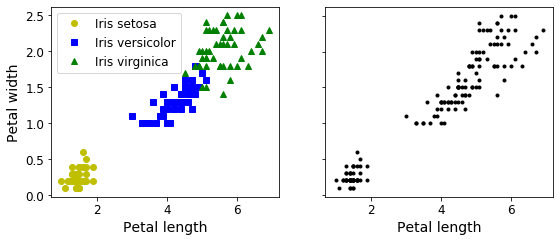

In [3]:
# plot classification vs clustering
plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

plt.show()

Many clustering algorithms can easily detect the bottom left cluster. It is also quite easy to see with our own eyes, but it is not so obvious that the upper right cluster is actually composed of two distinct sub-clusters. That said, the dataset actually has two additional features (sepal length and width), not represented here, and clustering algorithms can make good use of all features, so in fact they identify the three clusters fairly well.

##### Applications

- For customer segmentation: you can cluster your customers based on their pur‐ chases, their activity on your website, and so on. This is useful to understand who your customers are and what they need, so you can adapt your products and marketing campaigns to each segment (recommender systems).

- For data analysis: when analyzing a new dataset, it is often useful to first discover clusters of similar instances.

- As a dimensionality reduction technique: once a dataset has been clustered, it is usually possible to measure each instance’s affinity with each cluster (affinity is any measure of how well an instance fits into a cluster). Each instance’s feature vector x can then be replaced with the vector of its cluster affinities. If there are k clusters, then this vector is k dimensional.

- For anomaly detection (also called outlier detection): any instance that has a low affinity to all the clusters is likely to be an anomaly (fraud detection). 

- For semi-supervised learning: if you only have a few labels, you could perform clustering and propagate the labels to all the instances in the same cluster.

- For search engines: for example, some search engines let you search for images that are similar to a reference image. To build such a system, you would first apply a clustering algorithm to all the images in your database: similar images would end up in the same cluster.

- To segment an image: by clustering pixels according to their color, then replacing each pixel’s color with the mean color of its cluster, it is possible to reduce the number of different colors in the image considerably (object detection, tracking systems).

There is no universal definition of what a cluster is: it really depends on the context, and different algorithms will capture different kinds of clusters. For example, some algorithms look for instances centered around a particular point, called a centroid. Others look for continuous regions of densely packed instances: these clusters can take on any shape. Some algorithms are hierarchical, looking for clusters of clusters.

##### K-Means

Consider this next unlabeled dataset.

In [4]:
# generate some blobs
from sklearn.datasets import make_blobs

blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [5]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

In [6]:
# plot the blobs
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

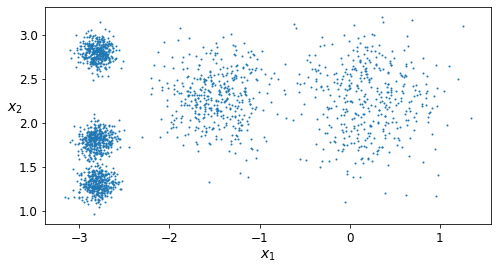

In [7]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

The K-Means algorithm is a simple algorithm capable of clustering this kind of dataset very quickly and efficiently, often in just a few iterations. 

In [8]:
from sklearn.cluster import KMeans

k = 5 # we clearly see 5 clusters
kmeans = KMeans(n_clusters=5)
y_pred = kmeans.fit_predict(X)

In the context of clustering, an instance’s label is the index of the cluster that this instance gets assigned to by the algorithm: this is not to be confused with the class labels in classification. 

The KMeans instance preserves a copy of the labels of the instances it was trained on, available via the labels_ instance variable:

In [9]:
y_pred

array([4, 0, 1, ..., 2, 1, 0], dtype=int32)

In [10]:
y_pred is kmeans.labels_ # 

True

In [11]:
# look at the 5 centroids used
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

We can easily assign new instances to the cluster whose centroid is closest:

In [12]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 2, 2], dtype=int32)

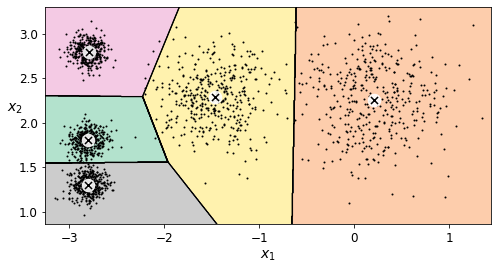

In [13]:
# decision boundaries plot
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
        
        
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

K-Means algorithm does not behave very well when the blobs have very different diameters since all it cares about when assigning an instance to a cluster is the distance to the centroid, but all in all, the vast majority of the instances were clearly assigned to the appropriate cluster.

Instead of assigning each instance to a single cluster, which is called hard clustering, it can be useful to just give each instance a score per cluster: this is called soft clustering. For example, the score can be the distance between the instance and the centroid, or conversely it can be a similarity score (or affinity) such as the Gaussian Radial Basis Function.

In [14]:
kmeans.transform(X_new)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

In this example, the first instance in X_new is located at a distance of 2.81 from the first centroid, 0.33 from the second centroid, 2.90 from the third centroid, 1.49 from the fourth centroid and 2.87 from the fifth centroid.

Let’s look at a few ways you can mitigate this risk by improving the centroid initialization.

##### Centroid initialization methods

If you happen to know approximately where the centroids should be, then you can set the init hyperparameter to a NumPy array containing the list of centroids, and set n_init to 1:

In [15]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1)
kmeans.fit_predict(X)

array([2, 1, 4, ..., 0, 4, 1], dtype=int32)

Another solution is to run the algorithm multiple times with different random initializations and keep the best solution. This is controlled by the n_init hyperparameter: by default, it is equal to 10, which means that the whole algorithm described earlier actually runs 10 times when you call fit(), and Scikit-Learn keeps the best solution.

The performance metric used is called the model’s inertia: this is the mean squared distance between each instance and its closest centroid. The KMeans class runs the algorithm n_init times and keeps the model with the lowest inertia.

In [16]:
kmeans.inertia_

211.5985372581684

In [17]:
kmeans.score(X)

-211.59853725816845

##### Accelerated K-Means and mini-batch K-Means

Instead of using the full dataset at each iteration, the algorithm is capable of using mini-batches, moving the centroids just slightly at each iteration. This speeds up the algorithm typically by a factor of 3 or 4 and makes it possible to cluster huge datasets that do not fit in memory. 



In [18]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=5, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [19]:
minibatch_kmeans.inertia_

211.93186531476786

Although the Mini-batch K-Means algorithm is much faster than the regular K- Means algorithm, its inertia is generally slightly worse, especially as the number of clusters increases. 

##### Finding the optimal number of clusters

In general, it will not be so easy to know how to set k, and the result might be quite bad if we set it to the wrong value.

The inertia is not a good performance metric when trying to choose k since it keeps get‐ ting lower as we increase k. Indeed, the more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be. 

In [20]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]

inertias = [model.inertia_ for model in kmeans_per_k]

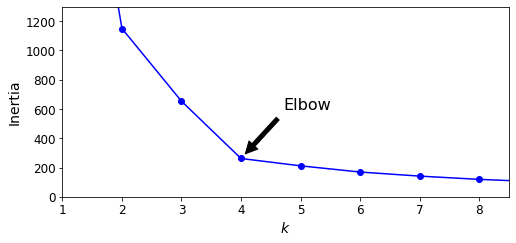

In [21]:
# inertia vs k plot
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
plt.show()

As we can see, the inertia drops very quickly as we increase k up to 4, but then it decreases much more slowly as we keep increasing k. This curve has roughly the shape of an arm, and there is an “elbow” at k=4 so if we did not know better, it would be a good choice: any lower value would be dramatic, while any higher value would not help much.

A more precise approach (but also more computationally expensive) is to use the sil‐ houette score, which is the mean silhouette coefficient over all the instances. 

An instance’s silhouette coefficient is equal to (b – a) / max(a, b) where a is the mean distance to the other instances in the same cluster (it is the mean intra-cluster distance), and b is the mean nearest-cluster distance, that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes b, excluding the instance’s own cluster). 

The silhouette coefficient can vary between -1 and +1: a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

In [22]:
from sklearn.metrics import silhouette_score

silhouette_score(X, kmeans.labels_)

0.655517642572828

In [23]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

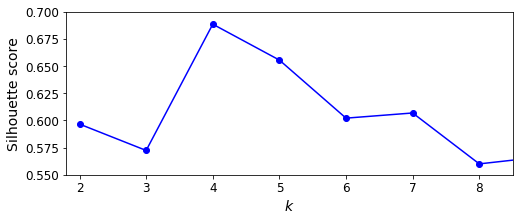

In [24]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

As we can see, this visualization is much richer than the previous one: in particular, although it confirms that k=4 is a very good choice, it also underlines the fact that k=5 is quite good as well, and much better than k=6 or 7. This was not visible when comparing inertias.



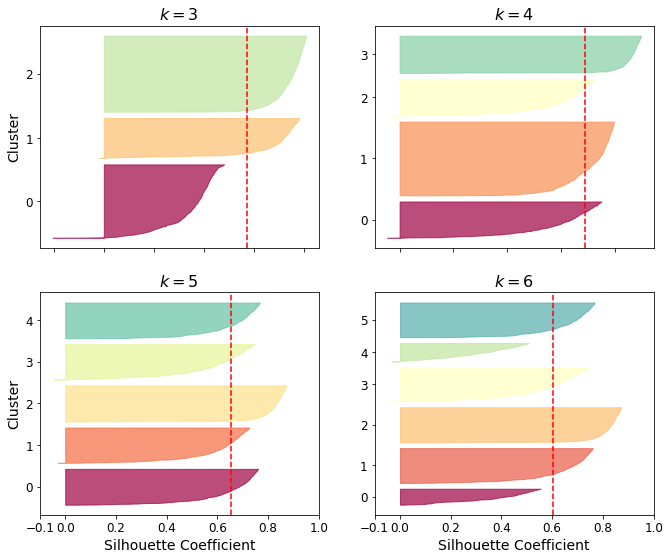

In [25]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

An even more informative visualization is obtained when you plot every instance’s silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. 

The vertical dashed lines represent the silhouette score for each number of clusters.

When most of the instances in a cluster have a lower coefficient than this score, then the cluster is rather bad since this means its instances are much too close to other clusters.

We can see that when k=3 and when k=6, we get bad clusters. But when k=4 or k=5, the clusters look pretty good – most instances extend beyond the dashed line, to the right and closer to 1.0. 

##### Using K-Means for image segmentation

Image segmentation is the task of partitioning an image into multiple segments. In semantic segmentation, all pixels that are part of the same object type get assigned to the same segment.

For example, in a self-driving car’s vision system, all pixels that are part of a pedestrian’s image might be assigned to the “pedestrian” segment.

In instance segmentation, all pixels that are part of the same individual object are assigned to the same segment. In this case there would be a different segment for each pedestrian.

we are going to do something much simpler: color segmentation. We will simply assign pixels to the same segment if they have a similar color. In some applications, this may be sufficient, for example if you want to analyze satellite images to measure how much total forest area there is in a region, color segmentation may be just fine.

In [32]:
# load image
from matplotlib.image import imread

path = '/Users/dsanchez/Code/Data_works/oreilly_skc_keras_tnsflw/chapter9/images/unsupervised_learning/ladybug.png'

image = imread(os.path.join('images', 'clustering', 'ladybug.png'))

FileNotFoundError: [Errno 2] No such file or directory: 'images/clustering/ladybug.png'

The image is represented as a 3D array: the first dimension’s size is the height, the second is the width, and the third is the number of color channels, in this case red, green and blue (RGB).

In other words, for each pixel there is a 3D vector containing the intensities of red, green and blue, each between 0.0 and 1.0 (or between 0 and 255 if it's not normalized).

Some images may have less channels, such as grayscale images (one channel), or more channels, such as images with an additional alpha channel for transparency, or satellite images which often contain channels for many light frequencies (e.g., infrared).

In [ ]:
# reshapes the array to get a long list of RGB colors, then it clusters these colors using K-Means.
X = image.reshape(-1, 3)

kmeans = KMeans(m_clusters=8).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

